
# GPU and batched data augmentation with Kornia and PyTorch-Lightning

* **Author:** PL/Kornia team
* **License:** CC BY-SA
* **Generated:** 2024-09-01T12:33:43.702411

In this tutorial we will show how to combine both Kornia and PyTorch Lightning
to perform efficient data augmentation to train a simple model using the GPU in batch
mode without additional effort.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/augmentation_kornia.ipynb)

Give us a ⭐ [on Github](https://www.github.com/Lightning-AI/lightning/)
| Check out [the documentation](https://lightning.ai/docs/)
| Join us [on Discord](https://discord.com/invite/tfXFetEZxv)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "matplotlib" "seaborn" "torch>=1.8.1, <2.5" "torchmetrics>=1.0, <1.5" "pandas" "numpy <3.0" "kornia" "pytorch-lightning >=2.0,<2.5" "torchvision"

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sn
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from IPython.display import display
from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomHorizontalFlip, RandomThinPlateSpline
from pytorch_lightning.loggers import CSVLogger
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

sn.set()

/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Define Data Augmentations module

[Kornia](https://github.com/kornia/kornia) is low level Computer Vision library that provides a dedicated module
[`kornia.augmentation`](https://kornia.readthedocs.io/en/latest/augmentation.html) module implementing
en extensive set of data augmentation techniques for image and video.

Similar to Lightning, in Kornia it's promoted to encapsulate functionalities inside classes for readability
and efficiency purposes. In this case, we define a data augmentaton pipeline subclassing a `nn.Module`
where the augmentation_kornia (also subclassing `nn.Module`) are combined with other PyTorch components
such as `nn.Sequential`.

Checkout the different augmentation operators in Kornia docs and experiment yourself!

In [3]:
class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self, apply_color_jitter: bool = False) -> None:
        super().__init__()
        self._apply_color_jitter = apply_color_jitter

        self.transforms = nn.Sequential(
            RandomHorizontalFlip(p=0.75),
            RandomChannelShuffle(p=0.75),
            RandomThinPlateSpline(p=0.75),
        )

        self.jitter = ColorJitter(0.5, 0.5, 0.5, 0.5)

    @torch.no_grad()  # disable gradients for efficiency
    def forward(self, x: Tensor) -> Tensor:
        x_out = self.transforms(x)  # BxCxHxW
        if self._apply_color_jitter:
            x_out = self.jitter(x_out)
        return x_out

## Define a Pre-processing module

In addition to the `DataAugmentation` modudle that will sample random parameters during the training stage,
we define a `Preprocess` class to handle the conversion of the image type to properly work with `Tensor`.

For this example we use `torchvision` CIFAR10 which return samples of `PIL.Image`, however,
to take all the advantages of PyTorch and Kornia we need to cast the images into tensors.

To do that we will use `kornia.image_to_tensor` which casts and permutes the images in the right format.

In [4]:
class Preprocess(nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""

    @torch.no_grad()  # disable gradients for efficiency
    def forward(self, x) -> Tensor:
        x_tmp: np.ndarray = np.array(x)  # HxWxC
        x_out: Tensor = image_to_tensor(x_tmp, keepdim=True)  # CxHxW
        return x_out.float() / 255.0

## Define PyTorch Lightning model

The next step is to define our `LightningModule` to have a proper organisation of our training pipeline.
This is a simple example just to show how to structure your baseline to be used as a reference,
do not expect a high performance.

Notice that the `Preprocess` class is injected into the dataset and will be applied per sample.

The interesting part in the proposed approach happens inside the `training_step` where with just a single
line of code we apply the data augmentation in batch and no need to worry about the device.
This means that our `DataAugmentation` pipeline will automatically executed in the GPU.

In [5]:
class CoolSystem(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # not the best model: expereiment yourself
        self.model = torchvision.models.resnet18(pretrained=True)
        self.preprocess = Preprocess()  # per sample transforms
        self.transform = DataAugmentation()  # per batch augmentation_kornia
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=1000)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=1000)

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y)

    def show_batch(self, win_size=(10, 10)):
        def _to_vis(data):
            return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

        # get a batch from the training set: try with `val_datlaoader` :)
        imgs, labels = next(iter(self.train_dataloader()))
        imgs_aug = self.transform(imgs)  # apply transforms
        # use matplotlib to visualize
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs))
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs_aug))

    def on_after_batch_transfer(self, batch, dataloader_idx):
        x, y = batch
        if self.trainer.training:
            x = self.transform(x)  # => we perform GPU/Batched data augmentation
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.train_accuracy.update(y_hat, y)
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.train_accuracy, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.val_accuracy.update(y_hat, y)
        self.log("valid_loss", loss, prog_bar=False)
        self.log("valid_acc", self.val_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.trainer.max_epochs, 0)
        return [optimizer], [scheduler]

    def prepare_data(self):
        CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)

    def train_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=32)
        return loader

    def val_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=32)
        return loader

## Visualize images

In [6]:
# init model
model = CoolSystem()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  7%|▋         | 3.12M/44.7M [00:00<00:01, 32.7MB/s]

 18%|█▊        | 7.88M/44.7M [00:00<00:00, 42.5MB/s]

 28%|██▊       | 12.4M/44.7M [00:00<00:00, 44.6MB/s]

 38%|███▊      | 16.8M/44.7M [00:00<00:00, 41.9MB/s]

 51%|█████     | 22.9M/44.7M [00:00<00:00, 49.4MB/s]

 62%|██████▏   | 27.8M/44.7M [00:00<00:00, 49.2MB/s]

 73%|███████▎  | 32.5M/44.7M [00:00<00:00, 49.0MB/s]

 83%|████████▎ | 37.2M/44.7M [00:00<00:00, 48.9MB/s]

 94%|█████████▍| 42.0M/44.7M [00:00<00:00, 48.8MB/s]

100%|██████████| 44.7M/44.7M [00:00<00:00, 47.3MB/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 196608/170498071 [00:00<01:45, 1615231.29it/s]

  1%|          | 1966080/170498071 [00:00<00:16, 10284368.19it/s]

  4%|▍         | 6881280/170498071 [00:00<00:06, 27195305.29it/s]

  7%|▋         | 11730944/170498071 [00:00<00:04, 35359961.63it/s]

 10%|▉         | 16613376/170498071 [00:00<00:03, 40038311.87it/s]

 13%|█▎        | 21463040/170498071 [00:00<00:03, 42872127.33it/s]

 15%|█▌        | 26345472/170498071 [00:00<00:03, 44780712.75it/s]

 18%|█▊        | 31227904/170498071 [00:00<00:03, 45998222.02it/s]

 21%|██        | 35880960/170498071 [00:00<00:02, 45402744.73it/s]

 24%|██▎       | 40468480/170498071 [00:01<00:03, 42225823.27it/s]

 26%|██▋       | 44761088/170498071 [00:01<00:02, 41916612.09it/s]

 29%|██▉       | 49020928/170498071 [00:01<00:03, 39014559.02it/s]

 31%|███▏      | 53641216/170498071 [00:01<00:02, 40967762.11it/s]

 34%|███▍      | 57868288/170498071 [00:01<00:02, 41225125.07it/s]

 36%|███▋      | 62062592/170498071 [00:01<00:02, 41207679.07it/s]

 39%|███▉      | 66224128/170498071 [00:01<00:02, 40378161.48it/s]

 41%|████      | 70287360/170498071 [00:01<00:02, 39744598.68it/s]

 44%|████▎     | 74285056/170498071 [00:01<00:02, 36834179.69it/s]

 47%|████▋     | 79560704/170498071 [00:02<00:02, 41177424.87it/s]

 49%|████▉     | 83755008/170498071 [00:02<00:02, 38202176.13it/s]

 51%|█████▏    | 87687168/170498071 [00:02<00:02, 36034023.35it/s]

 54%|█████▎    | 91389952/170498071 [00:02<00:02, 35577119.24it/s]

 56%|█████▌    | 94994432/170498071 [00:02<00:02, 32121099.74it/s]

 58%|█████▊    | 98664448/170498071 [00:02<00:02, 33245973.97it/s]

 60%|█████▉    | 102072320/170498071 [00:02<00:02, 30301750.44it/s]

 62%|██████▏   | 105218048/170498071 [00:02<00:02, 28304644.15it/s]

 63%|██████▎   | 108134400/170498071 [00:03<00:02, 27293118.36it/s]

 65%|██████▌   | 110919680/170498071 [00:03<00:02, 26860403.28it/s]

 67%|██████▋   | 113639424/170498071 [00:03<00:02, 26363413.29it/s]

 68%|██████▊   | 116293632/170498071 [00:03<00:02, 26363598.40it/s]

 70%|██████▉   | 118947840/170498071 [00:03<00:02, 24515570.62it/s]

 71%|███████   | 121438208/170498071 [00:03<00:02, 22549908.51it/s]

 73%|███████▎  | 123731968/170498071 [00:03<00:02, 21440560.69it/s]

 74%|███████▍  | 125927424/170498071 [00:03<00:02, 20481082.78it/s]

 75%|███████▌  | 128024576/170498071 [00:04<00:02, 15156702.27it/s]

 76%|███████▋  | 130088960/170498071 [00:04<00:02, 16314307.90it/s]

 77%|███████▋  | 131989504/170498071 [00:04<00:02, 16924067.92it/s]

 79%|███████▊  | 134053888/170498071 [00:04<00:02, 17842388.76it/s]

 80%|███████▉  | 136118272/170498071 [00:04<00:01, 18550699.68it/s]

 81%|████████  | 138248192/170498071 [00:04<00:01, 19249332.05it/s]

 82%|████████▏ | 140312576/170498071 [00:04<00:01, 19521834.37it/s]

 83%|████████▎ | 142344192/170498071 [00:04<00:01, 19459804.26it/s]

 85%|████████▍ | 144506880/170498071 [00:04<00:01, 20051888.68it/s]

 86%|████████▌ | 146702336/170498071 [00:04<00:01, 20584096.19it/s]

 87%|████████▋ | 148897792/170498071 [00:05<00:01, 20943210.27it/s]

 89%|████████▊ | 151027712/170498071 [00:05<00:00, 19808267.92it/s]

 90%|████████▉ | 153059328/170498071 [00:05<00:00, 18332361.75it/s]

 91%|█████████ | 154927104/170498071 [00:05<00:00, 17372465.39it/s]

 92%|█████████▏| 156696576/170498071 [00:05<00:00, 16487030.34it/s]

 93%|█████████▎| 158367744/170498071 [00:05<00:00, 16444170.71it/s]

 94%|█████████▍| 160038912/170498071 [00:05<00:00, 15962926.21it/s]

 95%|█████████▍| 161677312/170498071 [00:05<00:00, 16069676.32it/s]

 96%|█████████▌| 163348480/170498071 [00:06<00:00, 16244244.48it/s]

 97%|█████████▋| 164986880/170498071 [00:06<00:00, 15422580.15it/s]

 98%|█████████▊| 166559744/170498071 [00:06<00:00, 14634700.55it/s]

 99%|█████████▊| 168067072/170498071 [00:06<00:00, 13632499.93it/s]

 99%|█████████▉| 169476096/170498071 [00:06<00:00, 13135071.82it/s]

100%|██████████| 170498071/170498071 [00:06<00:00, 25925237.54it/s]

Extracting /__w/13/s/cifar-10-python.tar.gz to /__w/13/s


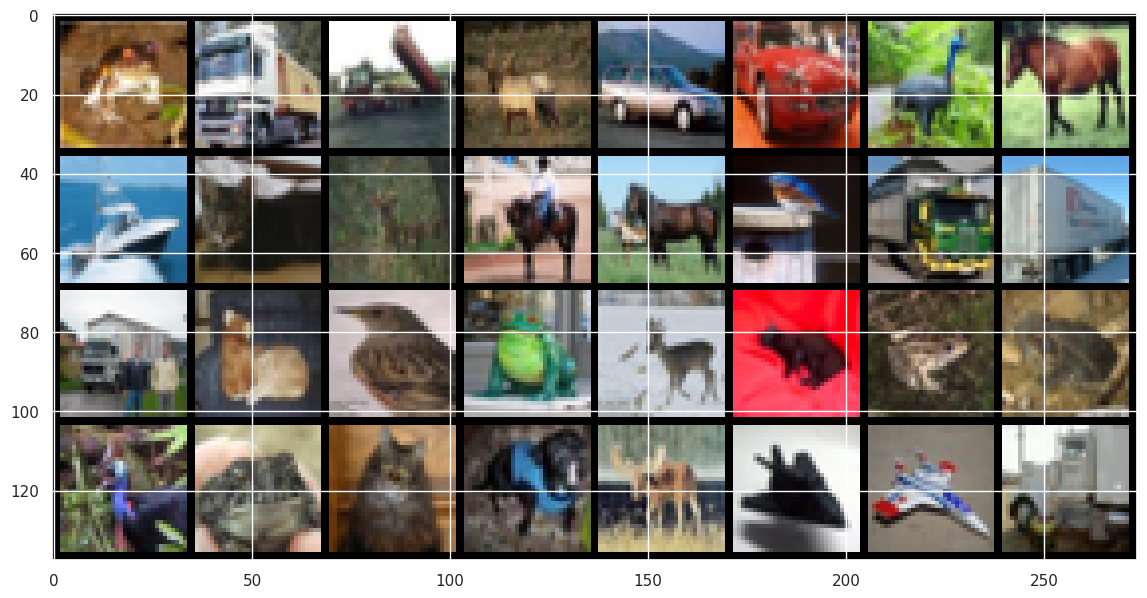

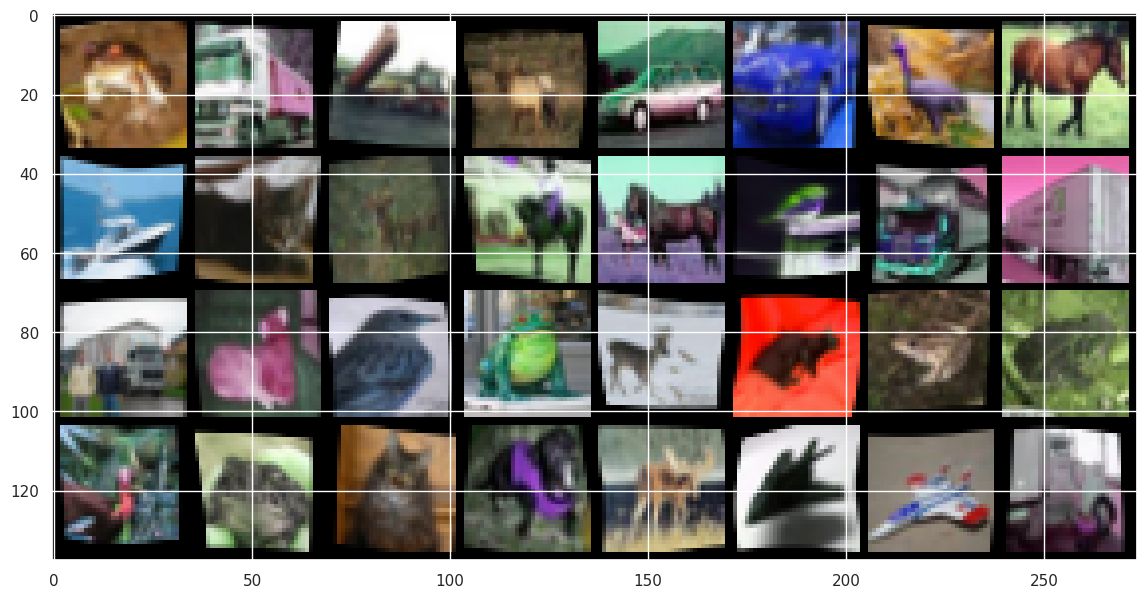

In [7]:
model.show_batch(win_size=(14, 14))

## Run training

In [8]:
# Initialize a trainer
trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)

# Train the model ⚡
trainer.fit(model)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Missing logger folder: logs/lightning_logs


Files already downloaded and verified


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ResNet             | 11.7 M | train
1 | preprocess     | Preprocess         | 0      | train
2 | transform      | DataAugmentation   | 0      | train
3 | train_accuracy | MulticlassAccuracy | 0      | train
4 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Visualize the training results

,train_loss,valid_acc,valid_loss
epoch,,,
0,4.444744,NaN,NaN
0,2.492729,NaN,NaN
0,2.296075,NaN,NaN
0,2.458903,NaN,NaN
0,2.176069,NaN,NaN


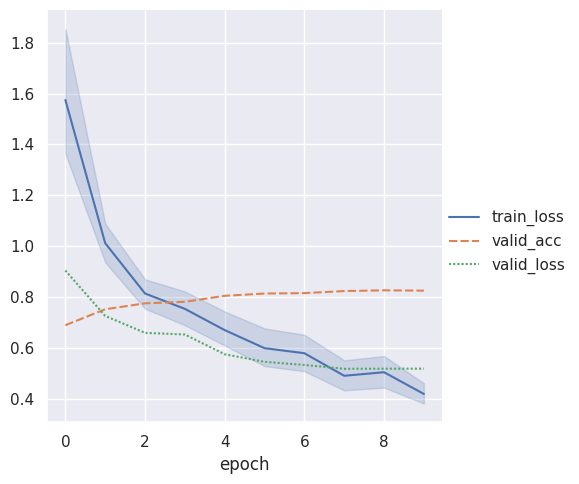

In [9]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/Lightning-AI/lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Discord](https://discord.com/invite/tfXFetEZxv)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/Lightning-AI/lightning) or [Bolt](https://github.com/Lightning-AI/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/Lightning-AI/lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/Lightning-AI/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)